In [1]:
import pyxatu
import matplotlib.pyplot as plt


xatu = pyxatu.PyXatu()

2025-07-04 18:07:46,335 - INFO - Clickhouse configs set
2025-07-04 18:07:46,336 - INFO - Clickhouse URL: https://clickhouse.xatu.ethpandaops.io, User: bosul


Config Path:  /Users/munboseol/.pyxatu_config.json


2025-07-04 18:07:46,614 - INFO - Status code: 200
2025-07-04 18:07:46,615 - INFO - Content-Length: 871
2025-07-04 18:07:46,615 - INFO - First 100 chars of response: updated_date_time
block_slot
block_slot_start_date_time
block_epoch
block_epoch_start_date_time
posi
2025-07-04 18:07:46,795 - INFO - Status code: 200
2025-07-04 18:07:46,795 - INFO - Content-Length: 858
2025-07-04 18:07:46,796 - INFO - First 100 chars of response: event_date_time
slot
slot_start_date_time
propagation_slot_start_diff
committee_index
attesting_vali
2025-07-04 18:07:46,966 - INFO - Status code: 200
2025-07-04 18:07:46,967 - INFO - Content-Length: 1222
2025-07-04 18:07:46,967 - INFO - First 100 chars of response: updated_date_time
event_date_time
slot
slot_start_date_time
epoch
epoch_start_date_time
block_root
b
2025-07-04 18:07:47,150 - INFO - Status code: 200
2025-07-04 18:07:47,151 - INFO - Content-Length: 707
2025-07-04 18:07:47,151 - INFO - First 100 chars of response: updated_date_time
event_date_time
sl

In [3]:
import pandas as pd
import numpy as np
import time


def get_block_base_fee_per_gas(block_numbers_str):
    blocks = xatu.get_el_blocks(
        columns="block_number, base_fee_per_gas",
        where=f"block_number IN ({block_numbers_str})"
    )
    
    return blocks

def get_blob_inclusion_delay(start_slot, end_slot):
    
    slots = xatu.get_slots(
        slot=[start_slot, end_slot],
        columns="slot, slot_start_date_time, execution_payload_block_number"
    )
    
    block_numbers = slots['execution_payload_block_number'].tolist()
    block_numbers_str = ', '.join(str(bn) for bn in block_numbers)
    
    block_info = get_block_base_fee_per_gas(block_numbers_str)
    
    blob_txs = xatu.get_el_transactions(
        columns="transaction_hash, transaction_type, max_fee_per_gas, max_priority_fee_per_gas, block_number",
        where=f"transaction_type=3 AND block_number IN ({block_numbers_str})"
    )
    
    if len(blob_txs) == 0:
        return None

    tx_hashes = blob_txs['transaction_hash'].tolist()
    
    hash_list = "', '".join([h.lower() for h in tx_hashes])
    where_condition = f"LOWER(hash) IN ('{hash_list}')"
    
    mempool_data = xatu.get_mempool(
        slot=[start_slot, end_slot],
        columns="hash, event_date_time as first_mempool_time, blob_hashes",
        where=where_condition,
    )
    time.sleep(2)
    mempool_data = mempool_data.loc[mempool_data.groupby("hash")["first_mempool_time"].idxmin()]
    
    mempool_data['transaction_hash'] = mempool_data['hash'].str.lower()
    blob_txs['transaction_hash_lower'] = blob_txs['transaction_hash'].str.lower()
    
    result = blob_txs.merge(
        mempool_data[['transaction_hash', 'first_mempool_time', 'blob_hashes']], 
        left_on='transaction_hash_lower',
        right_on='transaction_hash',
        how='left'
    )
    result = result.drop(columns=[
        'transaction_hash_y',   
        'transaction_hash_lower'
    ])
    result = result.rename(columns={
        'transaction_hash_x': 'transaction_hash'
    })
    
    result = result.merge(
        slots[['execution_payload_block_number', 'slot_start_date_time']],
        left_on='block_number',
        right_on='execution_payload_block_number',
        how='left'
    )
    
    result = result.drop(columns=['execution_payload_block_number'])
    
    result = result.merge(
        block_info[['block_number', 'base_fee_per_gas']],
        left_on='block_number',
        right_on='block_number',
        how='left'
    )
    
    result['slot_start_date_time'] = pd.to_datetime(result['slot_start_date_time'])
    result['first_mempool_time'] = pd.to_datetime(result['first_mempool_time'])
    result['delay_seconds'] = (result['slot_start_date_time'] - result['first_mempool_time']).dt.total_seconds()
    
    result = result.dropna(subset=['delay_seconds'])
    
    result['delay_slot'] = (result['delay_seconds'] / 12).apply(lambda x: max(1, int(x) + 1))
    
    result['effective_gas_priority_fee'] = np.minimum(result['max_fee_per_gas'] - result['base_fee_per_gas'], result['max_priority_fee_per_gas'])
    
    result = result.sort_values(by='effective_gas_priority_fee')
    return result

start_slot = 11869900
end_slot = 11870000
chunk_size = 50

all_results = []

for current_start in range(start_slot, end_slot, chunk_size):
    current_end = min(current_start + chunk_size, end_slot)
    chunk_result = get_blob_inclusion_delay(current_start, current_end)
    
    if chunk_result is not None:
        all_results.append(chunk_result)

if all_results:
    result = pd.concat(all_results, ignore_index=True)
else:
    result = None
    
if 'result' in globals() and result is not None and len(result) > 0:
    def get_blob_count(blob_hashes):
        if pd.isna(blob_hashes) or blob_hashes is None:
            return 0
        if isinstance(blob_hashes, (list, tuple)):
            return len(blob_hashes)
        elif isinstance(blob_hashes, str):
            try:
                import json
                parsed = json.loads(blob_hashes)
                if isinstance(parsed, list):
                    return len(parsed)
                else:
                    return 1 if parsed else 0
            except:
                if ',' in blob_hashes:
                    return len(blob_hashes.split(','))
                else:
                    return 1 if blob_hashes.strip() else 0
        else:
            return 1 if blob_hashes else 0
    
    result['blob_count'] = result['blob_hashes'].apply(get_blob_count)
        
else:
    print("There is no result data")

2025-07-04 18:13:05,045 - INFO - Executing query: SELECT DISTINCT slot, slot_start_date_time, execution_payload_block_number FROM canonical_beacon_block FINAL WHERE slot_start_date_time >= '2025-06-07 02:20:23' AND slot_start_date_time < '2025-06-07 02:30:23' AND slot >= 11869900 AND slot < 11869950 AND meta_network_name = 'mainnet'
2025-07-04 18:13:05,646 - INFO - Status code: 200
2025-07-04 18:13:05,646 - INFO - Content-Length: 1862
2025-07-04 18:13:05,646 - INFO - First 100 chars of response: 11869902	2025-06-07 02:20:47	22649686
11869905	2025-06-07 02:21:23	22649689
11869906	2025-06-07 02:2
2025-07-04 18:13:05,647 - INFO - Query executed in 0.60 seconds
2025-07-04 18:13:05,654 - INFO - Executing query: SELECT DISTINCT block_number, base_fee_per_gas FROM canonical_execution_block FINAL WHERE block_number IN (22649686, 22649689, 22649690, 22649691, 22649699, 22649707, 22649712, 22649716, 22649717, 22649718, 22649719, 22649720, 22649729, 22649684, 22649687, 22649702, 22649703, 2264970

In [4]:
print(f"\n=== Blob Count Statistics ===")
print(f"Avg. number of blobs: {result['blob_count'].mean():.2f}")
print(f"Avg. delay: {result['delay_slot'].mean():.2f}")
print(f"Min. number of blobs: {result['blob_count'].min()}")
print(f"Max. number of blobs: {result['blob_count'].max()}")
print(f"\nTransaction distribution by blob count:")
blob_count_dist = result['blob_count'].value_counts().sort_index()
for count, num_txs in blob_count_dist.items():
    percentage = (num_txs / len(result) * 100)
    print(f"{count} blob: {num_txs} ({percentage:.1f}%)")


=== Blob Count Statistics ===
Avg. number of blobs: 3.26
Avg. delay: 1.36
Min. number of blobs: 1
Max. number of blobs: 6

Transaction distribution by blob count:
1 blob: 18 (18.0%)
3 blob: 60 (60.0%)
4 blob: 1 (1.0%)
5 blob: 2 (2.0%)
6 blob: 19 (19.0%)


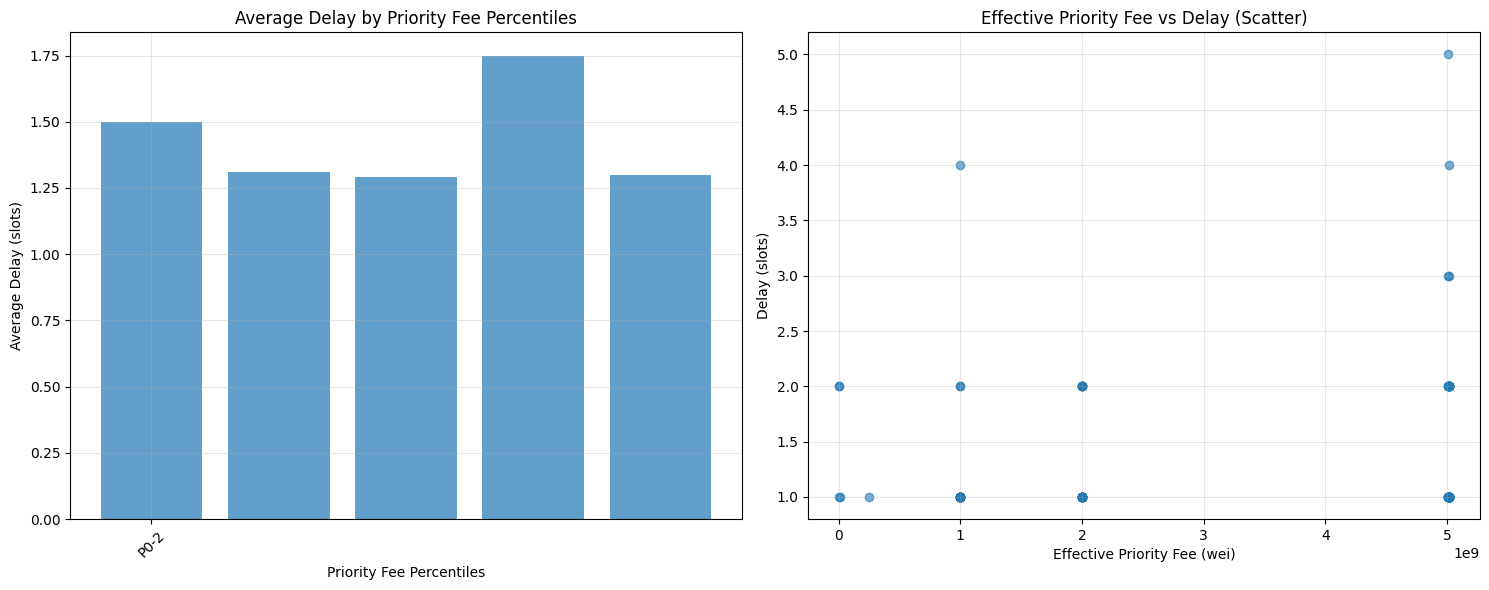

                  avg_delay_slot     fee_min     fee_max       fee_avg  \
priority_fee_bin                                                         
0                           1.50       70000    10000000  2.556000e+06   
1                           1.31   250000000  1000000000  9.531250e+08   
3                           1.29  2000000000  2000000000  2.000000e+09   
4                           1.75  5010000000  5010000000  5.010000e+09   
5                           1.30  5020000000  5020000000  5.020000e+09   

                  tx_count  
priority_fee_bin            
0                        4  
1                       16  
3                       21  
4                       12  
5                       47  

Blob Count vs Inclusion Delay


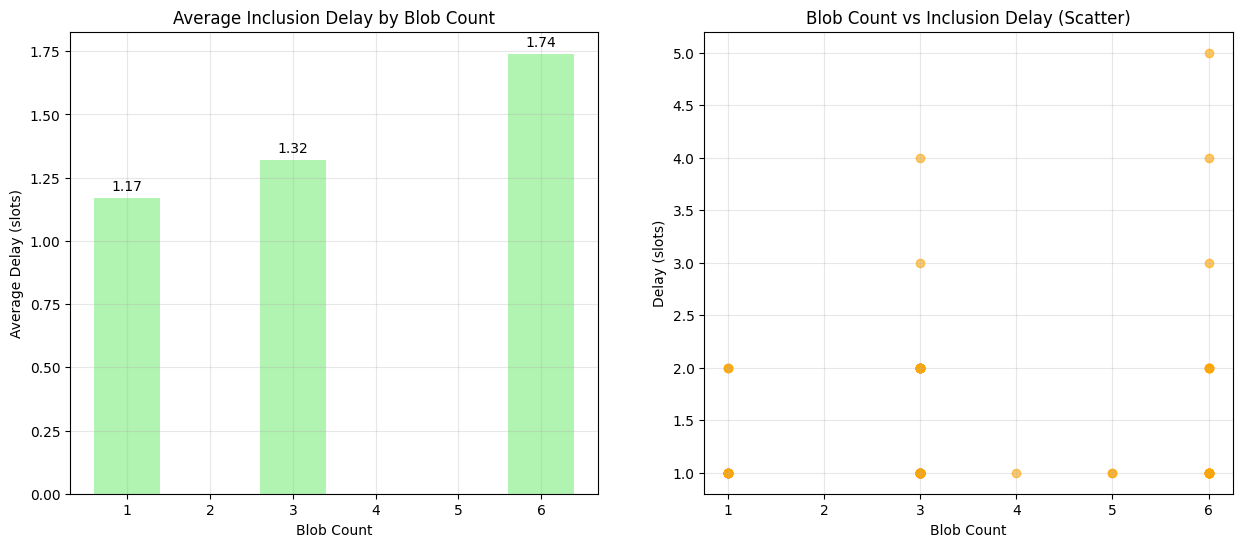

            avg_delay  median_delay  std_delay  tx_count
blob_count                                              
1                1.17           1.0       0.38        18
3                1.32           1.0       0.60        60
6                1.74           1.0       1.15        19


In [5]:

if result is not None and len(result) > 0:
    result['priority_fee_bin'] = pd.qcut(
        result['effective_gas_priority_fee'], 
        q=25,  # (4%)
        labels=False,
        duplicates='drop'
    )
    
    bin_stats = result.groupby('priority_fee_bin').agg({
        'delay_slot': 'mean',
        'effective_gas_priority_fee': ['min', 'max', 'mean'],
        'transaction_hash': 'count'
    }).round(2)
    
    bin_stats.columns = ['avg_delay_slot', 'fee_min', 'fee_max', 'fee_avg', 'tx_count']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    percentile_labels = [f"P{i*2}-{(i+1)*2}" for i in range(len(bin_stats))]
    ax1.bar(range(len(bin_stats)), bin_stats['avg_delay_slot'], alpha=0.7)
    ax1.set_xlabel('Priority Fee Percentiles')
    ax1.set_ylabel('Average Delay (slots)')
    ax1.set_title('Average Delay by Priority Fee Percentiles')
    ax1.set_xticks(range(0, len(bin_stats), 5))  # 5개씩 건너뛰어서 표시
    ax1.set_xticklabels([percentile_labels[i] for i in range(0, len(bin_stats), 5)], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    ax2.scatter(result['effective_gas_priority_fee'], result['delay_slot'], alpha=0.6)
    ax2.set_xlabel("Effective Priority Fee (wei)")
    ax2.set_ylabel("Delay (slots)")
    ax2.set_title("Effective Priority Fee vs Delay (Scatter)")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(bin_stats)
    
    if 'blob_count' in result.columns:
        print("\n" + "="*50)
        print("Blob Count vs Inclusion Delay")
        print("="*50)
        
        blob_delay_stats = result.groupby('blob_count').agg({
            'delay_slot': ['mean', 'median', 'std', 'count']
        }).round(2)
        
        blob_delay_stats.columns = ['avg_delay', 'median_delay', 'std_delay', 'tx_count']
        blob_delay_stats = blob_delay_stats[blob_delay_stats['tx_count'] >= 3]  # 최소 3개 이상
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        ax1.bar(blob_delay_stats.index, blob_delay_stats['avg_delay'], alpha=0.7, color='lightgreen')
        ax1.set_xlabel('Blob Count')
        ax1.set_ylabel('Average Delay (slots)')
        ax1.set_title('Average Inclusion Delay by Blob Count')
        ax1.grid(True, alpha=0.3)
        
        for i, v in enumerate(blob_delay_stats['avg_delay']):
            ax1.text(blob_delay_stats.index[i], v + max(blob_delay_stats['avg_delay']) * 0.01, 
                    f'{v:.2f}', ha='center', va='bottom', fontsize=10)
        
        ax2.scatter(result['blob_count'], result['delay_slot'], alpha=0.6, color='orange')
        ax2.set_xlabel('Blob Count')
        ax2.set_ylabel('Delay (slots)')
        ax2.set_title('Blob Count vs Inclusion Delay (Scatter)')
        ax2.grid(True, alpha=0.3)
        
        plt.show()
        
        
        print(blob_delay_stats)
    
else:
    print("no data to analyze")

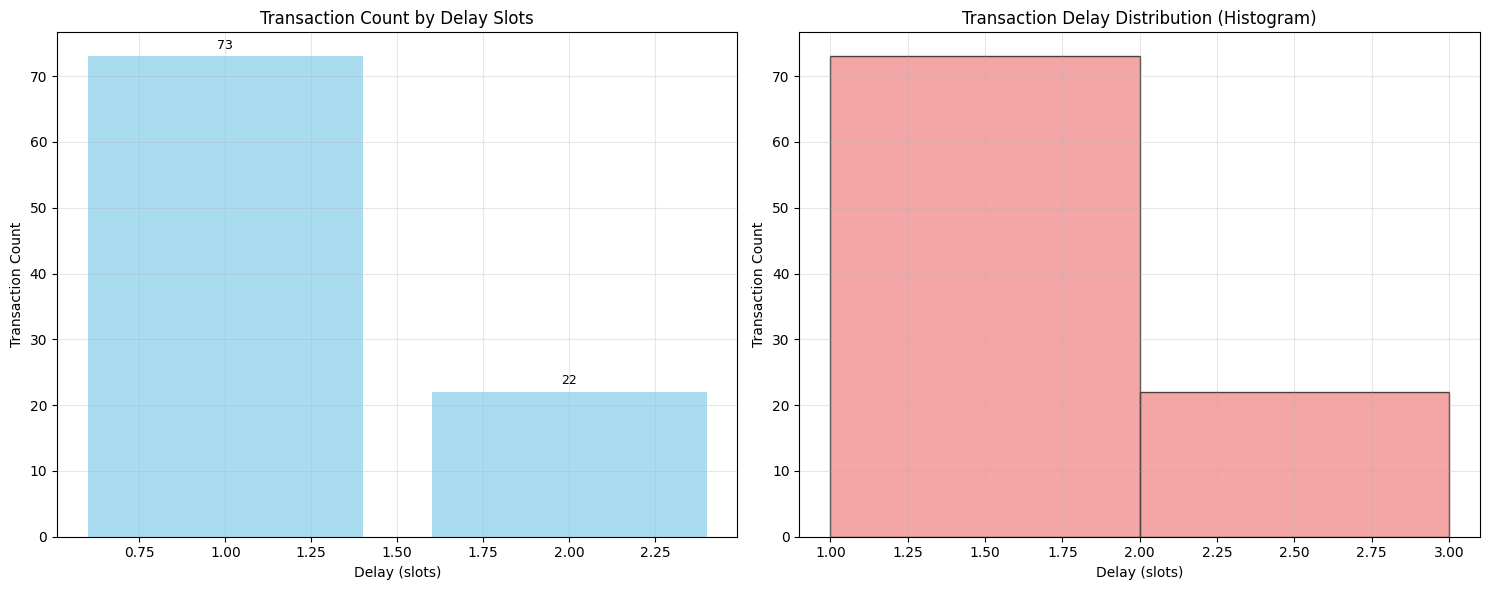

=== Delay Slot Statistics ===
Total transactions: 100
Average delay: 1.36 slots
Median delay: 1.0 slots
Min delay: 1 slots
Max delay: 5 slots

=== Delay Slot Distribution === (> 10 tx)
1 slot(s): 73 txs (73.0%)
2 slot(s): 22 txs (22.0%)


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

if 'result' in globals() and result is not None and len(result) > 0:
    slot_counts = result['delay_slot'].value_counts()

    valid_slots = slot_counts[slot_counts > 10].index
    filtered_result = result[result['delay_slot'].isin(valid_slots)]

    if len(filtered_result) == 0:
        print("All delay slots have only one transaction. Nothing to show.")
    else:
        delay_counts = filtered_result['delay_slot'].value_counts().sort_index()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.bar(delay_counts.index, delay_counts.values, alpha=0.7, color='skyblue')
        ax1.set_xlabel('Delay (slots)')
        ax1.set_ylabel('Transaction Count')
        ax1.set_title('Transaction Count by Delay Slots')
        ax1.grid(True, alpha=0.3)
        for i, v in enumerate(delay_counts.values):
            ax1.text(delay_counts.index[i], v + max(delay_counts.values) * 0.01, str(v),
                     ha='center', va='bottom', fontsize=9)

        ax2.hist(filtered_result['delay_slot'], bins=range(1, int(filtered_result['delay_slot'].max()) + 2),
                 alpha=0.7, color='lightcoral', edgecolor='black')
        ax2.set_xlabel('Delay (slots)')
        ax2.set_ylabel('Transaction Count')
        ax2.set_title('Transaction Delay Distribution (Histogram)')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("=== Delay Slot Statistics ===")
        print(f"Total transactions: {len(result)}")
        print(f"Average delay: {result['delay_slot'].mean():.2f} slots")
        print(f"Median delay: {result['delay_slot'].median()} slots")
        print(f"Min delay: {result['delay_slot'].min()} slots")
        print(f"Max delay: {result['delay_slot'].max()} slots")

        print("\n=== Delay Slot Distribution === (> 10 tx)")
        delay_percentages = (delay_counts / len(result) * 100).round(2)
        for delay, percentage in delay_percentages.items():
            print(f"{delay} slot(s): {delay_counts[delay]} txs ({percentage}%)")
else:
    print("Result data is not available. Please run the earlier cell.")

